In [1]:
import torch
import torch.nn as nn
import torchvision

In [2]:
# device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {DEVICE}")

device: cuda


In [3]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1) 
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        return x

In [4]:
# Check the block
encoder_block = Block(1, 64)
x = torch.rand(1, 1, 60, 60)
print(f'Shape of the encoder block: {encoder_block(x).shape}')

Shape of the encoder block: torch.Size([1, 64, 60, 60])


In [5]:
class Encoder(nn.Module):
    def __init__(self, channels=(1, 64, 128, 256, 512)):
        super().__init__()
        self.encoder_blocks = nn.ModuleList(
            [Block(channels[i], channels[i + 1]) for i in range(len(channels) - 1)]
        )
        self.pool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        block_outputs = []
        for block in self.encoder_blocks:
            x = block(x)
            block_outputs.append(x)
            x = self.pool(x)
        return block_outputs

In [6]:
# Check the encoder
encoder = Encoder()
x = torch.rand(1, 1, 60, 60)
encoder_outputs = encoder(x)

for op in encoder_outputs:
    print(f'Shape of the encoder output: {op.shape}')

Shape of the encoder output: torch.Size([1, 64, 60, 60])
Shape of the encoder output: torch.Size([1, 128, 30, 30])
Shape of the encoder output: torch.Size([1, 256, 15, 15])
Shape of the encoder output: torch.Size([1, 512, 7, 7])


In [7]:
class Decoder(nn.Module):
    def __init__(self, channels=(512, 256, 128, 64)):
        super().__init__()
        self.channels = channels
        self.decoder_blocks = nn.ModuleList(
            [Block(channels[i], channels[i + 1]) for i in range(len(channels) - 1)]
        )
        self.upconvolution = nn.ModuleList(
            [nn.ConvTranspose2d(channels[i], channels[i + 1], kernel_size=2, stride=2) for i in range(len(channels) - 1)]
        )

    def forward(self, x, encoder_outputs):
        for i in range(len(self.channels) - 1):
            x = self.upconvolution[i](x)
            encoder_output = self.crop(encoder_outputs[i], x)
            x = torch.cat([x, encoder_output], dim=1)
            x = self.decoder_blocks[i](x)
        return x

    # Following the paper, we crop the encoder output to match the shape of decoder output    
    def crop(self, encoder_output, tensor):
        _, _, H, W = tensor.shape
        encoder_output = torchvision.transforms.CenterCrop([H, W])(encoder_output)
        return encoder_output

In [8]:
# Check the decoder
decoder = Decoder()
x = torch.rand(1, 512, 7, 7)
decoder(x, encoder_outputs[::-1][1:]) # Pass the encoder outputs in reverse order
print(f'Shape of the decoder output: {decoder(x, encoder_outputs[::-1][1:]).shape}')

Shape of the decoder output: torch.Size([1, 64, 56, 56])


### UNet model

<p align="center">
  <img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" width=45% />
</p>

Reference: https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net

In [9]:
class UNet(nn.Module):
    def __init__(self, encoder_channels=(1, 64, 128, 256, 512), decoder_channels=(512, 256, 128, 64), num_classes=5, retain_dim=False, output_size=(60, 60)):
        super().__init__()
        self.encoder = Encoder(encoder_channels)
        self.decoder = Decoder(decoder_channels)
        self.head = nn.Conv2d(decoder_channels[-1], 1, kernel_size=1)
        self.retain_dim = retain_dim
        self.output_size = output_size

    def forward(self, x):
        encoder_outputs = self.encoder(x)
        out = self.decoder(encoder_outputs[-1], encoder_outputs[::-1][1:])
        out = self.head(out)
        if self.retain_dim:
            out = nn.functional.interpolate(out, self.output_size)
        return out

In [10]:
# Check the model
model = UNet(retain_dim=True)
x = torch.rand(1, 1, 60, 60)
out = model(x)
print(f'Shape of the model output: {out.shape}')

Shape of the model output: torch.Size([1, 1, 60, 60])


### Import libraries

In [11]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from torchinfo import summary
import cv2
from typing import List, Tuple
from PIL import Image
import imutils
from pathlib import Path
import pprint

import torchmetrics

import config
import dataset_generation
import utils

import importlib
importlib.reload(dataset_generation)

2024-04-15 05:22:35.787046: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-15 05:22:35.812185: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 05:22:36.437815: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<module 'dataset_generation' from '/home/kpatel2s/work/bmw/unet_task_3/sdp/unet_segmentation/dataset_generation.py'>

### Load hyperparameters

In [12]:
NUM_WORKERS = config.NUM_WORKERS
BATCH_SIZE = config.BATCH_SIZE
PIN_MEMORY = config.PIN_MEMORY

num_classes = config.NUM_CLASSES

EPOCHS = config.EPOCHS
LR_RATE = config.LR_RATE

TRAIN_VAL_SPLIT = config.TRAIN_VAL_SPLIT

### Load the dataset

In [13]:
train_x, train_y, test_x, test_y = dataset_generation.mnist_extended_dataset(total_train_samples=1000, total_test_samples=100, num_classes=num_classes)

print(f'Shape of train_x: {train_x.shape}')
print(f'Shape of train_y: {train_y.shape}')

Loading mnist dataset...
Processing mnist dataset...
Dataset ready!
Shape of train_x: (1000, 60, 60, 1)
Shape of train_y: (1000, 60, 60, 5)


### Create data loaders

In [14]:
# Convert ground truth labels from one-hot encoding to class indices
train_y_cls = np.argmax(train_y, axis=-1)
test_y_cls = np.argmax(test_y, axis=-1)
train_y_cls += 1
test_y_cls += 1

train_background_mask = np.sum(train_y, axis=-1) == 0
test_background_mask = np.sum(test_y, axis=-1) == 0

train_y_cls[train_background_mask] = 0
test_y_cls[test_background_mask] = 0

print(f'Shape of train_y (one-hot): {train_y.shape}')
print(f'Shape of train_y_cls (class indices): {train_y_cls.shape}')

print(f'Shape of test_y (one-hot): {test_y.shape}')
print(f'Shape of test_y_cls (class indices): {test_y_cls.shape}')

Shape of train_y (one-hot): (1000, 60, 60, 5)
Shape of train_y_cls (class indices): (1000, 60, 60)
Shape of test_y (one-hot): (100, 60, 60, 5)
Shape of test_y_cls (class indices): (100, 60, 60)


In [15]:
from torch.utils.data import random_split

# Convert numpy arrays to PyTorch tensors
train_x, train_y_cls, test_x, test_y_cls = [torch.tensor(arr, dtype=torch.float32) for arr in [train_x, train_y_cls, test_x, test_y_cls]]

train_data = list(zip(train_x, train_y_cls))
test_data = list(zip(test_x, test_y_cls))

# Divide the train data into train and validation sets
train_data_len = len(train_data)
train_data_len = int(train_data_len * TRAIN_VAL_SPLIT)
train_data, val_data = random_split(train_data, [train_data_len, len(train_data) - train_data_len])

print(f'Shape of train_data: {len(train_data)}')
print(f'Shape of val_data: {len(val_data)}')
print(f'Shape of test_data: {len(test_data)}')

Shape of train_data: 900
Shape of val_data: 100
Shape of test_data: 100


In [16]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset=train_data, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True, 
                          num_workers=NUM_WORKERS, 
                          pin_memory=PIN_MEMORY)

val_loader = DataLoader(dataset=val_data,
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        num_workers=NUM_WORKERS,
                        pin_memory=PIN_MEMORY)

test_loader = DataLoader(dataset=test_data, 
                         batch_size=1, 
                         shuffle=False, 
                         num_workers=NUM_WORKERS, 
                         pin_memory=PIN_MEMORY)

print(f'Number of train batches: {len(train_loader)}')
print(f'Number of val batches: {len(val_loader)}')
print(f'Number of test batches: {len(test_loader)}')

Number of train batches: 29
Number of val batches: 4
Number of test batches: 100


In [17]:
# Get a train input and output pair
i = np.random.randint(0, 500)
train_x_sample, train_y_sample = train_loader.dataset[i]
print(f'Shape of train_x_sample: {train_x_sample.shape}')
print(f'Shape of train_y_sample: {train_y_sample.shape}')

# get min and max of train y
train_y_min, train_y_max = train_y_sample.min(), train_y_sample.max()
print(f'Min and max of train_y_sample: {train_y_min}, {train_y_max}')

Shape of train_x_sample: torch.Size([60, 60, 1])
Shape of train_y_sample: torch.Size([60, 60])
Min and max of train_y_sample: 0.0, 3.0


In [18]:
train_x_sample.dtype, train_y_sample.dtype

(torch.float32, torch.float32)

### Visualize the dataset

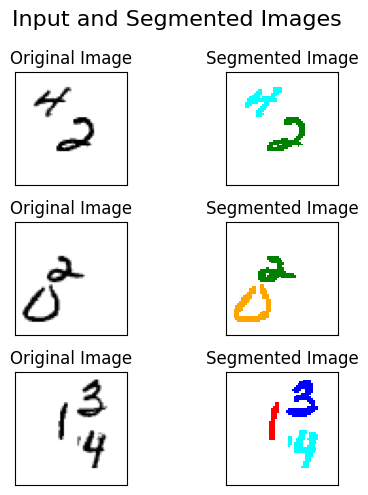

In [19]:
from matplotlib.colors import ListedColormap

# Create a colormap with specific colors for each class
colors = ['white', 'orange', 'red', 'green', 'blue', 'cyan']  # colors for classes 0 to 5
cmap = ListedColormap(colors)

# Sample indices for visualization
random_indices = np.random.choice(len(train_loader.dataset), size=6, replace=False)

# Create a figure with 3 rows and 2 columns
fig, axs = plt.subplots(3, 2, figsize=(5, 5))  # Adjust the figure size as needed

for i, ax in enumerate(axs.flat):
    idx = random_indices[i // 2]  # Integer division to ensure pairs
    data = train_loader.dataset[idx]

    if i % 2 == 0:  # Even indices for original images
        image = data[0]  # Assuming this is the input image
        ax.imshow(image, cmap=plt.cm.binary)  # Correctly order the dimensions if needed
        ax.set_title("Original Image")
    else:  # Odd indices for segmented images
        segmentation = data[1]  # Assuming this is the segmentation mask
        ax.imshow(segmentation, cmap=cmap, interpolation='none', vmin=0, vmax=5)  # Apply the predefined colormap
        ax.set_title("Segmented Image")

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')

fig.suptitle('Input and Segmented Images', fontsize=16)
plt.tight_layout()
plt.show()

### Load the model

In [23]:
unet_model = UNet(retain_dim=True, num_classes=num_classes, output_size=(60, 60)).to(DEVICE)

In [24]:
# Model summary
summary(model=unet_model,
        input_size=(1, 1, 60, 60),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"],
        depth=5
        )

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
UNet (UNet)                              [1, 1, 60, 60]       [1, 1, 60, 60]       --                   True
├─Encoder (encoder)                      [1, 1, 60, 60]       [1, 64, 60, 60]      --                   True
│    └─ModuleList (encoder_blocks)       --                   --                   (recursive)          True
│    │    └─Block (0)                    [1, 1, 60, 60]       [1, 64, 60, 60]      --                   True
│    │    │    └─Conv2d (conv1)          [1, 1, 60, 60]       [1, 64, 60, 60]      640                  True
│    │    │    └─ReLU (relu)             [1, 64, 60, 60]      [1, 64, 60, 60]      --                   --
│    │    │    └─Conv2d (conv2)          [1, 64, 60, 60]      [1, 64, 60, 60]      36,928               True
│    │    │    └─ReLU (relu)             [1, 64, 60, 60]      [1, 64, 60, 60]      --                   --
│    └─MaxPool2d (

### Loss function and optimizer

In [25]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(unet_model.parameters(), lr=LR_RATE)

### Training loop

In [26]:
utils.set_seed()

from timeit import default_timer as timer
start_time = timer()

# Store train and validation losses
train_losses = []
val_losses = []

for epoch in range(EPOCHS):

    unet_model.train()
    train_loss = []

    for idx, (x, y) in enumerate(train_loader):
        x = x.to(DEVICE).permute(0, 3, 1, 2)
        y = y.to(DEVICE).long()

        y_pred = unet_model(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
    
    val_loss = []

    with torch.no_grad():
        unet_model.eval()
        for idx, (x, y) in enumerate(val_loader):
            x = x.to(DEVICE).permute(0, 3, 1, 2)
            y = y.to(DEVICE).long()

            y_pred = unet_model(x)
            loss = loss_fn(y_pred, y)

            val_loss.append(loss.item())
    
    print(f'Epoch: {epoch + 1} / {EPOCHS}, Train Loss: {np.mean(train_loss):.5f}, Val Loss: {np.mean(val_loss):.5f}')

    train_losses.append(np.mean(train_loss))
    val_losses.append(np.mean(val_loss))
    

end_time = timer()
print(f'Total training time: {end_time - start_time:.2f} seconds')

RuntimeError: GET was unable to find an engine to execute this computation

### Plot losses

In [ ]:
# Plot train and validation loss over epochs
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.tight_layout()
plt.show()

### Calculate mean IoU

In [ ]:
import torchmetrics

# Calculate mean IoU
iou_metric = torchmetrics.JaccardIndex(task='multiclass', num_classes=num_classes).to(DEVICE)
unet_model.eval()
with torch.no_grad():
    iou_metric.reset()
    for idx, (x, y) in enumerate(test_loader):
        x = x.to(DEVICE).permute(0, 3, 1, 2)
        y = y.to(DEVICE).permute(0, 3, 1, 2)

        y_logits = unet_model(x)

        print(f'Shape of y_logits: {y_logits.shape}')

        y_pred = torch.softmax(y_logits, dim=1)

        print(f'Shape of y_pred softmax: {y_pred.shape}')
        # y_pred = torch.argmax(y_pred, dim=1)

        print(f'Shape of y_pred argmax: {y_pred.shape}')

        iou_metric(y_pred, y)

        # Show progress
        print(f'\rProcessing image {idx + 1}/{len(test_loader)}', end='')
        break
    
    print(f'Mean IoU: {iou_metric.compute():.5f}')

    iou_metric.reset()